In [1]:
import os
from skimage.data import imread
from skimage.morphology import label
import pandas as pd
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

input_dir = '/home/user/Desktop/airbus-ship-detection/'
train_img_dir = '/home/user/Desktop/airbus-ship-detection/train/'
test_img_dir = '/home/user/Desktop/airbus-ship-detection/test/'

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv(input_dir+'train_ship_segmentations.csv')
test_df = pd.read_csv(input_dir+'test_ship_segmentations.csv')

In [3]:
train_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [4]:
train_df.shape

(131030, 2)

In [5]:
def area_isnull(x):
    if x == x:
        return 0
    else:
        return 1

In [6]:
train_df['isnan'] = train_df['EncodedPixels'].apply(area_isnull)

In [7]:
train_df['isnan'].value_counts()

1    75000
0    56030
Name: isnan, dtype: int64

In [8]:
train_df = train_df.sort_values('isnan', ascending=False)
train_df = train_df.iloc[:]

In [9]:
train_df['isnan'].value_counts()

1    75000
0    56030
Name: isnan, dtype: int64

In [10]:
def rle_to_mask(rle_list, SHAPE):
    tmp_flat = np.zeros(SHAPE[0]*SHAPE[1])
    if len(rle_list) == 1:
        mask = np.reshape(tmp_flat, SHAPE).T
    else:
        strt = rle_list[::2]
        length = rle_list[1::2]
        for i,v in zip(strt,length):
            tmp_flat[(int(i)-1):(int(i)-1)+int(v)] = 255
        mask = np.reshape(tmp_flat, SHAPE).T
    return mask

In [11]:
def calc_area_for_rle(rle_str):
    rle_list = [int(x) if x.isdigit() else x for x in str(rle_str).split()]
    if len(rle_list) == 1:
        return 0
    else:
        area = np.sum(rle_list[1::2])
        return area

In [12]:
train_df['area'] = train_df['EncodedPixels'].apply(calc_area_for_rle)

In [13]:
train_df_isship = train_df[train_df['area'] > 0]

In [14]:
train_df_isship.shape

(56030, 4)

In [15]:
train_df_smallarea = train_df_isship['area'][train_df_isship['area'] < 10]

In [16]:
train_df_smallarea.shape

(77,)

In [17]:
train_df_smallarea.shape[0]/train_df_isship.shape[0]

0.0013742637872568267

In [18]:
train_gp = train_df.groupby('ImageId').sum()
train_gp = train_gp.reset_index()

In [19]:
train_gp.head()

,ImageId,isnan,area
0,00003e153.jpg,1,0
1,000155de5.jpg,0,3388
2,00021ddc3.jpg,0,1176
3,0002756f7.jpg,0,408
4,0002d0f32.jpg,1,0


In [20]:
def calc_class(area):
    area = area / (768*768)
    if area == 0:
        return 0
    elif area < 0.005:
        return 1
    elif area < 0.015:
        return 2
    elif area < 0.025:
        return 3
    elif area < 0.035:
        return 4
    elif area < 0.045:
        return 5
    else:
        return 6

In [21]:
train_gp['class'] = train_gp['area'].apply(calc_class)

In [22]:
train_gp['class'].value_counts()

0    75000
1    20015
2     6303
3     1824
4      763
5      119
6       46
Name: class, dtype: int64

In [23]:
train, val0 = train_test_split(train_gp, test_size=0.01, stratify=train_gp['class'].tolist())

In [24]:
train_isship_list = train['ImageId'][train['isnan']==0].tolist()
train_isship_list = random.sample(train_isship_list, len(train_isship_list))
train_nanship_list = train['ImageId'][train['isnan']==1].tolist()
train_nanship_list = random.sample(train_nanship_list, len(train_nanship_list))

In [25]:
len(train_isship_list),len(train_nanship_list)

(28779, 74250)

In [26]:
def mygenerator(isship_list, nanship_list, batch_size, cap_num):
    train_img_names_nanship = isship_list[:cap_num]
    train_img_names_isship = nanship_list[:cap_num]
    k = 0
    while True:
        if k+batch_size//2 >= cap_num:
            k = 0
        batch_img_names_nan = train_img_names_nanship[k:k+batch_size//2]
        batch_img_names_is = train_img_names_isship[k:k+batch_size//2]
        batch_img = []
        batch_mask = []
        for name in batch_img_names_nan:
            tmp_img = imread(train_img_dir + name)
            batch_img.append(tmp_img)
            mask_list = train_df['EncodedPixels'][train_df['ImageId'] == name].tolist()
            one_mask = np.zeros((768, 768, 1))
            for item in mask_list:
                rle_list = str(item).split()
                tmp_mask = rle_to_mask(rle_list, (768, 768))
                one_mask[:,:,0] += tmp_mask
            batch_mask.append(one_mask)
        for name in batch_img_names_is:
            tmp_img = imread(train_img_dir + name)
            batch_img.append(tmp_img)
            mask_list = train_df['EncodedPixels'][train_df['ImageId'] == name].tolist()
            one_mask = np.zeros((768, 768, 1))
            for item in mask_list:
                rle_list = str(item).split()
                tmp_mask = rle_to_mask(rle_list, (768, 768))
                one_mask[:,:,0] += tmp_mask
            batch_mask.append(one_mask)
        img = np.stack(batch_img, axis=0)
        mask = np.stack(batch_mask, axis=0)
        img = img / 255.0
        mask = mask / 255.0
        k += batch_size//2
        yield img, mask

In [27]:
BATCH_SIZE = 2
CAP_NUM = min(len(train_isship_list),len(train_nanship_list))
datagen = mygenerator(train_isship_list, train_nanship_list, batch_size=BATCH_SIZE, cap_num=CAP_NUM)

In [28]:
## Simplify Unet

inputs = Input(shape=(768,768,3))
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv0 = BatchNormalization()(conv0)
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
conv0 = BatchNormalization()(conv0)
comp0 = AveragePooling2D((6,6))(conv0)

conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(comp0)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.4)(conv1)

pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.4)(conv2)

pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.4)(conv3)

pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(0.4)(conv4)

pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv5 = BatchNormalization()(conv5)

upcv6 = UpSampling2D(size=(2,2))(conv5)
upcv6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv6)
upcv6 = BatchNormalization()(upcv6)
mrge6 = concatenate([conv4, upcv6], axis=3)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upcv7 = UpSampling2D(size=(2,2))(conv6)
upcv7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv7)
upcv7 = BatchNormalization()(upcv7)
mrge7 = concatenate([conv3, upcv7], axis=3)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upcv8 = UpSampling2D(size=(2,2))(conv7)
upcv8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv8)
upcv8 = BatchNormalization()(upcv8)
mrge8 = concatenate([conv2, upcv8], axis=3)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

upcv9 = UpSampling2D(size=(2,2))(conv8)
upcv9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv9)
upcv9 = BatchNormalization()(upcv9)
mrge9 = concatenate([conv1, upcv9], axis=3)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

dcmp10 = UpSampling2D((6,6), interpolation='bilinear')(conv9)
mrge10 = concatenate([dcmp10, conv0], axis=3)
conv10 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge10)
conv10 = BatchNormalization()(conv10)
conv10 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
conv10 = BatchNormalization()(conv10)
conv11 = Conv2D(1, 1, activation='sigmoid')(conv10)

model = Model(inputs=inputs, outputs=conv11)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 768, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 768, 768, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 768, 768, 8)  584         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [29]:
##Traditional Unet

inputs = Input(shape=(768,768,3))

conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
merge6 = concatenate([drop4, up6])
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([conv3, up7])

conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8])

conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9])
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)


conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

model = Model(input=inputs, output=conv10)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 768, 768, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 768, 768, 64) 36928       conv2d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 384, 384, 64) 0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_30 

/home/user/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [30]:
##RGB Unet fail
inputs = Input(shape=(768,768,3))
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', dilation_rate=(2, 2))(conv5)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal', dilation_rate=(2, 2))(conv5)
conv5 = BatchNormalization()(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
merge6 = concatenate([drop4, up6])
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)
up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([conv3, up7])

conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)
up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8])

conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9])
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)


conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

model = Model(input=inputs, output=conv10)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 768, 768, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 768, 768, 64) 256         conv2d_52[0][0]                  
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 768, 768, 64) 36928       batch_normalization_27[0][0]     
__________________________________________________________________________________________________
batch_norm

/home/user/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [31]:
##RGB Unet
inputs = Input(shape=(768,768,3))
conv0 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv0 = BatchNormalization()(conv0)
conv0 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
conv0 = BatchNormalization()(conv0)
comp0 = AveragePooling2D((6,6))(conv0)

conv1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(comp0)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.4)(conv1)

pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.4)(conv2)

pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.4)(conv3)

pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(0.4)(conv4)

pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv5 = Conv2D(2048, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(2048, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv5 = BatchNormalization()(conv5)

upcv6 = UpSampling2D(size=(2,2))(conv5)
upcv6 = Conv2D(1024, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv6)
upcv6 = BatchNormalization()(upcv6)
mrge6 = concatenate([conv4, upcv6], axis=3)
conv6 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upcv7 = UpSampling2D(size=(2,2))(conv6)
upcv7 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv7)
upcv7 = BatchNormalization()(upcv7)
mrge7 = concatenate([conv3, upcv7], axis=3)
conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upcv8 = UpSampling2D(size=(2,2))(conv7)
upcv8 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv8)
upcv8 = BatchNormalization()(upcv8)
mrge8 = concatenate([conv2, upcv8], axis=3)
conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

upcv9 = UpSampling2D(size=(2,2))(conv8)
upcv9 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv9)
upcv9 = BatchNormalization()(upcv9)
mrge9 = concatenate([conv1, upcv9], axis=3)
conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

dcmp10 = UpSampling2D((6,6), interpolation='bilinear')(conv9)
mrge10 = concatenate([dcmp10, conv0], axis=3)
conv10 = Conv2D(81, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge10)
conv10 = BatchNormalization()(conv10)
conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
conv10 = BatchNormalization()(conv10)
conv11 = Conv2D(1, 1, activation='sigmoid')(conv10)

model = Model(inputs=inputs, outputs=conv11)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 768, 768, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 768, 768, 64) 256         conv2d_84[0][0]                  
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 768, 768, 64) 36928       batch_normalization_54[0][0]     
__________________________________________________________________________________________________
batch_norm

In [32]:
model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy')

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('/home/user/Desktop/airbus-ship-detection/model-unet3.h5', monitor='loss', verbose=1, save_best_only=True)
history = model.fit_generator(datagen, steps_per_epoch = 20000, epochs = 16, callbacks=[checkpointer])

In [33]:
def calc_IoU(A, B):
    AorB = np.logical_or(A,B).astype('int')
    AandB = np.logical_and(A,B).astype('int')
    IoU = AandB.sum() / AorB.sum()
    return IoU

In [34]:
def calc_IoU_vector(A, B):
    score_vector = []
    IoU = calc_IoU(A, B)
    for threshold in np.arange(0.5,1,0.05):
        score = int(IoU > threshold)
        score_vector.append(score)
    return score_vector

In [35]:
def calc_IoU_tensor(masks_true, masks_pred):
    true_mask_num = masks_true.shape[0]
    pred_mask_num = masks_pred.shape[0]
    score_tensor = np.zeros((true_mask_num, pred_mask_num, 10))
    for true_i in range(true_mask_num):
        for pred_i in range(pred_mask_num):
            true_mask = masks_true[true_i]
            pred_mask = masks_pred[pred_i]
            score_vector = calc_IoU_vector(true_mask, pred_mask)
            score_tensor[true_i,pred_i,:] = score_vector
    return score_tensor

In [36]:
def calc_F2_per_one_threshold(score_matrix):
    tp = np.sum( score_matrix.sum(axis=1) > 0  )
    fn = np.sum( score_matrix.sum(axis=1) == 0 )
    fp = np.sum( score_matrix.sum(axis=0) == 0 )
    F2 = (5*tp) / ((5*tp) + fp + (4*fn))
    return F2

In [37]:
def calc_score_one_image(mask_true, mask_pred):
    mask_true = mask_true.reshape(768,768)
    mask_pred = mask_pred.reshape(768,768)
    if mask_true.sum() == 0 and mask_pred.sum() == 0:
        score = 1
    elif mask_true.sum() == 0 and mask_pred.sum() != 0:
        score = 0
    elif mask_true.sum() != 0 and mask_pred.sum() == 0:
        score = 0
    else:
        mask_label_true = label(mask_true)
        mask_label_pred = label(mask_pred)
        c_true = np.max(mask_label_true)
        c_pred = np.max(mask_label_pred)
        tmp = []
        for k in range(c_true):
            tmp.append(mask_label_true == k+1)
        masks_true = np.stack(tmp, axis=0)
        tmp = []
        for k in range(c_pred):
            tmp.append(mask_label_pred == k+1)
        masks_pred = np.stack(tmp, axis=0)
        score_tensor = calc_IoU_tensor(masks_true, masks_pred)
        F2_t = []
        for i in range(10):
            F2 = calc_F2_per_one_threshold(score_tensor[:,:,i])
            F2_t.append(F2)
        score = np.mean(F2_t)
    return score

In [38]:
def calc_score_all_image(batch_mask_true, batch_mask_pred, threshold=0.5):
    num = batch_mask_true.shape[0]
    tmp = batch_mask_pred > threshold
    batch_mask_pred = tmp.astype('int')
    scores = list()
    for i in range(num):
        score = calc_score_one_image(batch_mask_true[i], batch_mask_pred[i])
        scores.append(score)
    return np.mean(scores)

In [39]:
val_list = val0['ImageId'].tolist()

In [40]:
def create_data(image_list):
    batch_img = []
    batch_mask = []
    for name in image_list:
        tmp_img = imread(train_img_dir + name)
        batch_img.append(tmp_img)
        mask_list = train_df['EncodedPixels'][train_df['ImageId'] == name].tolist()
        one_mask = np.zeros((768, 768, 1))
        for item in mask_list:
            rle_list = str(item).split()
            tmp_mask = rle_to_mask(rle_list, (768, 768))
            one_mask[:,:,0] += tmp_mask
        batch_mask.append(one_mask)
    img = np.stack(batch_img, axis=0)
    mask = np.stack(batch_mask, axis=0)
    img = img / 255.0
    mask = mask / 255.0
    return img, mask

In [41]:
from tqdm import tqdm

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [43]:
#model = load_model('/home/user/Desktop/airbus-ship-detection/traditional_unet.h5')
#model = load_model('/home/user/Desktop/airbus-ship-detection/rgb_unet.h5.h5')
model = load_model('/home/user/Desktop/airbus-ship-detection/simplify_unet.h5')
#model = load_model('/home/user/ship_model/unet_have5datagen.h5')
#search threshold
scores_list = dict()
threshold_list = [x/100 for x in range(50,100,5)]
for threshold in threshold_list:
    scores = []
    for i in tqdm(range(len(val_list)//2)):
        temp_list = val_list[i*2:(i+1)*2]
        val_img, val_mask = create_data(temp_list)
        pred_mask = model.predict(val_img)
        F2 = calc_score_all_image(val_mask, pred_mask, threshold=threshold)*2
        scores.append(F2)
    val_F2 = np.sum(scores)/(len(val_list)//2 *2)
    scores_list[threshold] = val_F2


 30%|██▉       | 155/520 [00:24<00:55,  6.62it/s]


 59%|█████▉    | 309/520 [00:47<00:35,  5.90it/s]


 89%|████████▉ | 463/520 [01:10<00:08,  6.77it/s]


100%|██████████| 520/520 [01:18<00:00,  6.06it/s]

 19%|█▉        | 98/520 [00:13<00:55,  7.54it/s]


 48%|████▊     | 252/520 [00:34<00:37,  7.15it/s]


 78%|███████▊  | 406/520 [00:55<00:15,  7.53it/s]


100%|██████████| 520/520 [01:11<00:00,  6.90it/s]

  8%|▊         | 40/520 [00:05<01:03,  7.52it/s]


 38%|███▊      | 195/520 [00:26<00:48,  6.75it/s]


 67%|██████▋   | 349/520 [00:48<00:22,  7.46it/s]


 97%|█████████▋| 503/520 [01:09<00:02,  7.39it/s]


100%|██████████| 520/520 [01:12<00:00,  6.90it/s]

 27%|██▋       | 138/520 [00:18<00:50,  7.60it/s]


 56%|█████▌    | 292/520 [00:40<00:33,  6.84it/s]


 86%|████████▌ | 446/520 [01:01<00:09,  7.47it/s]


100%|██████████| 520/520 [01:11<00:00,  6.99it/s]

 16%|█▌        | 81/520 [00:11<01:05,  6.68it/s]


 45%|████▌     | 235/520 [00:32<00:37,  7.58it/s]


 75%|███████▍  | 389/520 [00:53<00:19,  6.88it/s]


100%|██████████| 520/520 [01:11<00:00,  6.71it/s]

  4%|▍         | 23/520 [00:03<01:05,  7.57it/s]


 34%|███▍      | 179/520 [00:24<00:45,  7.55it/s]


 64%|██████▍   | 333/520 [00:45<00:25,  7.35it/s]


 94%|█████████▎| 487/520 [01:06<00:04,  7.64it/s]


100%|██████████| 520/520 [01:11<00:00,  6.54it/s]

 23%|██▎       | 122/520 [00:16<00:55,  7.22it/s]


 53%|█████▎    | 276/520 [00:37<00:31,  7.65it/s]


 83%|████████▎ | 430/520 [00:58<00:12,  7.37it/s]


100%|██████████| 520/520 [01:10<00:00,  7.14it/s]

 12%|█▎        | 65/520 [00:08<01:00,  7.52it/s]


 42%|████▏     | 220/520 [00:29<00:39,  7.63it/s]


 72%|███████▏  | 374/520 [00:50<00:19,  7.59it/s]


100%|██████████| 520/520 [01:10<00:00,  6.99it/s]

  2%|▏         | 8/520 [00:01<01:05,  7.76it/s]


 32%|███▏      | 164/520 [00:22<00:49,  7.22it/s]


 61%|██████    | 318/520 [00:42<00:26,  7.51it/s]


 91%|█████████ | 472/520 [01:03<00:06,  7.56it/s]


100%|██████████| 520/520 [01:10<00:00,  7.00it/s]

 21%|██        | 107/520 [00:14<00:55,  7.45it/s]


 50%|█████     | 261/520 [00:34<00:34,  7.45it/s]


 80%|███████▉  | 415/520 [00:55<00:13,  7.59it/s]


100%|██████████| 520/520 [01:09<00:00,  7.68it/s]


In [44]:
scores_list

{0.5: 0.6757151922137482,
 0.55: 0.6769945765635323,
 0.6: 0.683142268629899,
 0.65: 0.6825932703255795,
 0.7: 0.6860565887498178,
 0.75: 0.6846202396787312,
 0.8: 0.6833410896175873,
 0.85: 0.6894711596177421,
 0.9: 0.6940422927060371,
 0.95: 0.7025747863247863}

In [45]:
opt_threshold = max(scores_list, key=scores_list.get)

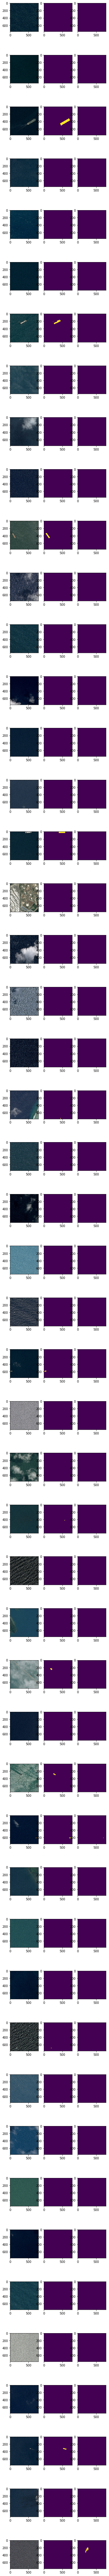

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
image_list = val_list[0:50]
fig, axes = plt.subplots(len(image_list), 3, figsize=(5,5*len(image_list)))
fig.subplots_adjust(left=0.075,right=0.95,bottom=0.05,top=0.52,wspace=0.2,hspace=0.10)
for i in range(len(image_list)):
    img = imread(train_img_dir + image_list[i])
    input_img, gt_mask = create_data([image_list[i]])
    pred_mask = model.predict(input_img)
    pred_mask = pred_mask > opt_threshold
    pred_mask = pred_mask.reshape(768,768,1)
    gt_mask = gt_mask * 255
    gt_mask = gt_mask.reshape(768,768)
    pred_mask = pred_mask.reshape(768,768)
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(gt_mask)
    axes[i, 2].imshow(pred_mask)